In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib.pyplot import cm
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pickle
import numpy as np
import random
from scipy.special import softmax as softmax
from math import ceil
from IPython.display import display, clear_output
from utils import *
sm0 = nn.Softmax(dim = 0)
sm1 = nn.Softmax(dim = 1)

In [3]:
# check if CUDA is available
torch.cuda.is_available()

True

In [4]:
Y = 2          #number of observations
M = 2          #number of memory states
A = 2          #number of actions
F = 1 + 1      #number of linear features (+ bias)

# optimizer parameters
lr = 0.01
n_epochs = 10
n_batch = 50
threshold_act = 30
dx = 125

# trajectories limited?
maxT = 5000 

# shuffle gradient position
x_pos_shuffle = False
x_max_shuffle = 5

# percentage of training data
train_perc = 80

In [5]:
# #Load the trajectories
# name_traj = "./samples/trjs_N500len500test.pkl"
# with open(name_traj, "rb") as f:
#     trjs_dict = pickle.load(f)

# # Splitting into train and test
# Neps = len(trjs_dict)
# Ntrain = int(Neps*train_perc/100)

# trjs_train = trjs_dict[:Ntrain]
# trjs_test = trjs_dict[Ntrain:]

In [6]:
# parameters for softmax policy
# dims: {Y, M, M', A} 
# F = #features + bias

#Start from a random theta ---default!
theta = torch.rand( (F, M, M, A), requires_grad=True, device='cuda')
theta.data = 2*theta.data-1
theta.data /= 5


#If you restart theta from a saved file
theta_is_from_restart = False

#If you start theta from a fixed set of numbers
theta_is_fixed = False

if theta_is_from_restart:
    theta_restart_file = "./results/virtual_data_antonio_FSC/theta_bacteria_FSC_M2_loglike431.11_th30_MselfconsTrue_FromRandom_FSCtrajs.dat"
    theta = torch.from_numpy(np.loadtxt(theta_restart_file).reshape(F,M,M,A))
elif theta_is_fixed:
    theta=np.array([[[[-0.61114431,-0.55987562],[ 0.59255672,0.82834098]],[[-0.88220033,0.46330714],[ 0.43192955,-0.52351326]]],
               [[[ 0.41101729,-0.31575377],[-0.64954147,0.36582982]],[[-0.24503104,0.00449758],[ 0.8396274,0.59647384]]]])
    theta=torch.from_numpy(theta.reshape(F,M,M,A))

In [7]:
#parameters for softmax of psi to get rho(m_0)
psi=torch.rand(M,requires_grad=True, device='cuda')
psi_uniform=False
if psi_uniform:
    psi=torch.ones(M,requires_grad=True)

In [8]:
sm0 = nn.Softmax(dim = 0)

In [9]:

#Produce trajectories
#ground_truth_theta=np.array([[[[-0.61114431,-0.55987562],[ 0.59255672,0.82834098]],[[-0.88220033,0.46330714],[ 0.43192955,-0.52351326]]], 
#[[[ 0.41101729,-0.31575377],[-0.64954147,0.36582982]],[[-0.24503104,0.00449758],[ 0.8396274,0.59647384]]]])


Ntraj=500
traj_len=100
signal=get_signal_landscape('step_like',traj_len,Ntraj)
dict_trajectories,original_theta = get_traj_from_theta(F,M,A,signal,'False',Ntraj,traj_len)

500 / 500


In [10]:
original_theta

array([[[[-0.9629398 ,  0.14707666],
         [-0.83063267,  0.88302487]],

        [[-0.21978671, -0.86869579],
         [-0.87569959, -0.42727133]]],


       [[[-0.74046244, -0.11874317],
         [-0.8246854 ,  0.62118121]],

        [[-0.0649276 , -0.23490731],
         [-0.14607044, -0.30270079]]]])

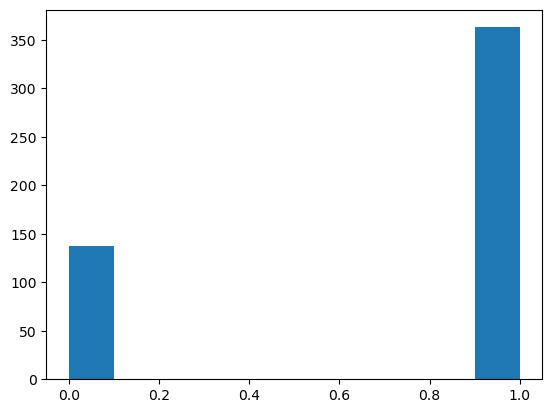

array([0.274, 0.726])

In [12]:
plt.hist([dict["memories"][0] for dict in dict_trajectories])
plt.show()

np.unique([dict["memories"][0] for dict in dict_trajectories], return_counts=True)[1]/Ntraj

In [13]:
trjs_dict=dict_trajectories
# Splitting into train and test
Neps = len(trjs_dict)
Ntrain = int(Neps*train_perc/100)

trjs_train = trjs_dict[:Ntrain]
trjs_test = trjs_dict[Ntrain:]

In [14]:
theta,psi

(tensor([[[[ 0.1450, -0.0189],
           [ 0.1528,  0.1927]],
 
          [[ 0.0591,  0.0914],
           [ 0.1113, -0.1871]]],
 
 
         [[[-0.1760,  0.0465],
           [ 0.0093,  0.0971]],
 
          [[-0.1522, -0.1391],
           [-0.0617,  0.0541]]]], device='cuda:0', requires_grad=True),
 tensor([0.3416, 0.4836], device='cuda:0', requires_grad=True))

In [15]:
nn.Softmax(dim=0)(psi)

tensor([0.4646, 0.5354], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [16]:
n_epochs = 20

In [17]:

# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
theta = theta.to(device)
psi = psi.to(device)

optimizer_theta = torch.optim.Adam([theta], lr=lr)
optimizer_psi = torch.optim.Adam([psi], lr=lr)

optimizer = torch.optim.Adam([theta, psi], lr=lr)

# if you want to use the same device for all tensors
torch.set_default_tensor_type('torch.cuda.FloatTensor')

count = 0

Neps = len(trjs_dict)

lr_mav = 1. / Ntrain

losses_train_theta = []
losses_test_theta = []

losses_train_psi = []
losses_test_psi = []

losses_train = []
losses_test = []

alternate_update = False

grad_required=True
for epochs in range(n_epochs):

    running_loss_theta = 0.
    running_loss_psi = 0.
    running_loss = 0.
    random.shuffle(trjs_train)

    for ibatch, batch in enumerate(batched(trjs_train, n_batch)):
        if alternate_update:
            # Update theta while keeping psi fixed
            loss_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
            loss_theta.backward()
            running_loss_theta += loss_theta.item()
                
            optimizer_theta.step()
            optimizer_theta.zero_grad()
            
            # Update theta while keeping psi fixed
            loss_psi= trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
            loss_psi.backward()
            running_loss_psi += loss_psi.item()
                
            optimizer_psi.step()
            optimizer_psi.zero_grad()
            
            
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_psi {loss_psi.item()}")
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_theta {loss_theta.item()}", end='\r')
        else:
            # update both theta and psi
            loss = trajs_loss_eval(theta, psi, batch, trjs_train)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss {loss.item()}", end='\r')
    if alternate_update:
        loss_test_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
        loss_test_psi = trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
    
        print(f"Epoch: {epochs} \tLoss train: {running_loss_theta/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_psi}")
        print(f"Epoch: {epochs} \tLoss train: {running_loss_psi/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_theta}")
        losses_train_theta.append(running_loss_theta)
        losses_train_psi.append(running_loss_psi)
        losses_test_theta.append(loss_test_theta)
        losses_test_psi.append(loss_test_psi)
    else:
        loss_test = trajs_loss_eval(theta, psi, batch, trjs_train)
        print(f"Epoch: {epochs} \tLoss train: {running_loss/ceil(Ntrain/n_batch)}")
        losses_train.append(running_loss)
        losses_test.append(loss_test)

        print(f"\t Initial distribution: {nn.Softmax(dim=0)(psi)}")

/home/giorgio/miniconda3/envs/minpy/lib/python3.11/site-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Epoch: 0 	Loss train: 68.65822996919393
	 Initial distribution: tensor([0.5023, 0.4977], grad_fn=<SoftmaxBackward0>)
Epoch: 1 	Loss train: 66.89736899444246
	 Initial distribution: tensor([0.5195, 0.4805], grad_fn=<SoftmaxBackward0>)
Epoch: 2 	Loss train: 66.38582924331207
	 Initial distribution: tensor([0.5003, 0.4997], grad_fn=<SoftmaxBackward0>)


In [142]:
n_epochs = 5

In [143]:

# use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
theta = theta.to(device)
psi = psi.to(device)

optimizer_theta = torch.optim.Adam([theta], lr=lr)
optimizer_psi = torch.optim.Adam([psi], lr=lr)

optimizer = torch.optim.Adam([theta, psi], lr=lr)

# if you want to use the same device for all tensors
torch.set_default_tensor_type('torch.cuda.FloatTensor')

count = 0

Neps = len(trjs_dict)

lr_mav = 1. / Ntrain

losses_train_theta = []
losses_test_theta = []

losses_train_psi = []
losses_test_psi = []

losses_train = []
losses_test = []

alternate_update = False

grad_required=True
for epochs in range(n_epochs):

    running_loss_theta = 0.
    running_loss_psi = 0.
    running_loss = 0.
    random.shuffle(trjs_train)

    for ibatch, batch in enumerate(batched(trjs_train, n_batch)):
        if alternate_update:
            # Update theta while keeping psi fixed
            loss_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
            loss_theta.backward()
            running_loss_theta += loss_theta.item()
                
            optimizer_theta.step()
            optimizer_theta.zero_grad()
            
            # Update theta while keeping psi fixed
            loss_psi= trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
            loss_psi.backward()
            running_loss_psi += loss_psi.item()
                
            optimizer_psi.step()
            optimizer_psi.zero_grad()
            
            
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_psi {loss_psi.item()}")
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_theta {loss_theta.item()}", end='\r')
        else:
            # update both theta and psi
            loss = trajs_loss_eval(theta, psi, batch, trjs_train)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss {loss.item()}", end='\r')
    if alternate_update:
        loss_test_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
        loss_test_psi = trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
    
        print(f"Epoch: {epochs} \tLoss train: {running_loss_theta/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_psi}")
        print(f"Epoch: {epochs} \tLoss train: {running_loss_psi/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_theta}")
        losses_train_theta.append(running_loss_theta)
        losses_train_psi.append(running_loss_psi)
        losses_test_theta.append(loss_test_theta)
        losses_test_psi.append(loss_test_psi)
    else:
        loss_test = trajs_loss_eval(theta, psi, batch, trjs_train)
        print(f"Epoch: {epochs} \tLoss train: {running_loss/ceil(Ntrain/n_batch)}")
        losses_train.append(running_loss)
        losses_test.append(loss_test)

        print(f"\t Initial distribution: {nn.Softmax(dim=0)(psi)}")

Epoch: 0 	Loss train: 55.060594883380574
	 Initial distribution: tensor([0.8511, 0.1489], grad_fn=<SoftmaxBackward0>)
Epoch: 1 	Loss train: 55.05383537603025
	 Initial distribution: tensor([0.8428, 0.1572], grad_fn=<SoftmaxBackward0>)
Epoch: 2 	Loss train: 55.047555039108154
	 Initial distribution: tensor([0.8356, 0.1644], grad_fn=<SoftmaxBackward0>)
Epoch: 3 	Loss train: 55.042400453463365
	 Initial distribution: tensor([0.8294, 0.1706], grad_fn=<SoftmaxBackward0>)
Epoch: 4 	Loss train: 55.03781994519788
	 Initial distribution: tensor([0.8256, 0.1744], grad_fn=<SoftmaxBackward0>)


In [150]:
grad_required=True
for epochs in range(n_epochs):

    running_loss_theta = 0.
    running_loss_psi = 0.
    running_loss = 0.
    random.shuffle(trjs_train)

    for ibatch, batch in enumerate(batched(trjs_train, n_batch)):
        if alternate_update:
            # Update theta while keeping psi fixed
            loss_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
            loss_theta.backward()
            running_loss_theta += loss_theta.item()
                
            optimizer_theta.step()
            optimizer_theta.zero_grad()
            
            # Update theta while keeping psi fixed
            loss_psi= trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
            loss_psi.backward()
            running_loss_psi += loss_psi.item()
                
            optimizer_psi.step()
            optimizer_psi.zero_grad()
            
            
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_psi {loss_psi.item()}")
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss_theta {loss_theta.item()}", end='\r')
        else:
            # update both theta and psi
            loss = trajs_loss_eval(theta, psi, batch, trjs_train)
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            print(f"Batch {ibatch+1}/{ceil(Ntrain/n_batch)}: loss {loss.item()}", end='\r')
    if alternate_update:
        loss_test_theta = trajs_loss_eval(theta, psi.detach(), batch, trjs_train)
        loss_test_psi = trajs_loss_eval(theta.detach(), psi, batch, trjs_train)
    
        print(f"Epoch: {epochs} \tLoss train: {running_loss_theta/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_psi}")
        print(f"Epoch: {epochs} \tLoss train: {running_loss_psi/ceil(Ntrain/n_batch)} \tLoss test: {loss_test_theta}")
        losses_train_theta.append(running_loss_theta)
        losses_train_psi.append(running_loss_psi)
        losses_test_theta.append(loss_test_theta)
        losses_test_psi.append(loss_test_psi)
    else:
        loss_test = trajs_loss_eval(theta, psi, batch, trjs_train)
        print(f"Epoch: {epochs} \tLoss train: {running_loss/ceil(Ntrain/n_batch)}")
        losses_train.append(running_loss)
        losses_test.append(loss_test)

        print(f"\t Initial distribution: {nn.Softmax(dim=0)(psi)}")

Epoch: 0 	Loss train: 55.03349660062381
	 Initial distribution: tensor([0.8259, 0.1741], grad_fn=<SoftmaxBackward0>)
Epoch: 1 	Loss train: 55.02920592334819
	 Initial distribution: tensor([0.8301, 0.1699], grad_fn=<SoftmaxBackward0>)
Epoch: 2 	Loss train: 55.02449706772866
	 Initial distribution: tensor([0.8368, 0.1632], grad_fn=<SoftmaxBackward0>)
Epoch: 3 	Loss train: 55.0192174497293
	 Initial distribution: tensor([0.8449, 0.1551], grad_fn=<SoftmaxBackward0>)
Epoch: 4 	Loss train: 55.01332293934659
	 Initial distribution: tensor([0.8540, 0.1460], grad_fn=<SoftmaxBackward0>)


In [151]:
nn.Softmax(dim=0)(psi)

tensor([0.8540, 0.1460], grad_fn=<SoftmaxBackward0>)

In [152]:
theta

tensor([[[[-0.0362, -0.0627],
          [-0.2971,  0.4285]],

         [[ 0.6432, -0.7863],
          [-0.2410,  0.0240]]],


        [[[-0.2395,  0.4461],
          [-0.0655,  0.0299]],

         [[ 0.3534, -0.3930],
          [-0.0440,  0.3929]]]], requires_grad=True)

In [153]:
pi_f(theta.detach().cpu().numpy(), f_traj[1], 0), pi_f(theta.detach().cpu().numpy(), f_traj[1], 1)

(array([0.23064303, 0.22461489, 0.17767354, 0.36706855]),
 array([0.4564469 , 0.10928453, 0.18852946, 0.24573911]))

In [154]:
pi_f(original_theta, f_traj[0], 0), pi_f(original_theta, f_traj[0], 1)

(array([0.14781318, 0.17739546, 0.47524408, 0.19954728]),
 array([0.18376921, 0.43676727, 0.25392884, 0.12553467]))

In [155]:
np_Tmm(theta.detach().cpu().numpy(), f_traj[1], 0), np_Tmm(theta.detach().cpu().numpy(), f_traj[1], 1)

(array([[0.1155057 , 0.08897865],
        [0.22785895, 0.09411418]]),
 array([[0.11248681, 0.1838274 ],
        [0.054555  , 0.12267332]]))

In [156]:
np_Tmm(original_theta, f_traj[0], 0), np_Tmm(original_theta, f_traj[0], 1)

(array([[0.06244315, 0.20076516],
        [0.10613657, 0.14665752]]),
 array([[0.07494007, 0.08429803],
        [0.25225651, 0.072503  ]]))